# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias_copy = azdias.copy()
customers_copy = customers.copy()

### 0.1 Mixed type data

As loading the data set, there is a warning: `typeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.`, which means column 18 and 19 have miss valued data. 

In [4]:
azdias.iloc[:,18].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [5]:
customers.iloc[:,18].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [6]:
azdias.iloc[:,19].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [7]:
customers.iloc[:,19].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

We can find that "X" in column 18 and "XX" in column 19 cause the warning message. We will replace the two values with NaN values in later.

### 0.2 Data Description

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


From the infomation above, we know that there are 6 attributes of string type, which need to be converted to numerical ones.

In [9]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [11]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [12]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [13]:
azdias.dtypes

LNR                       int64
AGER_TYP                  int64
AKT_DAT_KL              float64
ALTER_HH                float64
ALTER_KIND1             float64
                         ...   
WOHNDAUER_2008          float64
WOHNLAGE                float64
ZABEOTYP                  int64
ANREDE_KZ                 int64
ALTERSKATEGORIE_GROB      int64
Length: 366, dtype: object

In [14]:
customers.dtypes

LNR                       int64
AGER_TYP                  int64
AKT_DAT_KL              float64
ALTER_HH                float64
ALTER_KIND1             float64
                         ...   
PRODUCT_GROUP            object
CUSTOMER_GROUP           object
ONLINE_PURCHASE           int64
ANREDE_KZ                 int64
ALTERSKATEGORIE_GROB      int64
Length: 369, dtype: object

In [4]:
print("The shape of AZIDIAS:", azdias.shape)
print("The shape of CUSTOMERS:", customers.shape)

The shape of AZIDIAS: (891221, 366)
The shape of CUSTOMERS: (191652, 369)


We noticed that `CUSTOMERS` has 369 attributes but `AZIDIAS` has 366 attributes. There are 3 attributes unknown to `AZIDIAS`:

In [4]:
set(customers.columns).difference(set(azdias.columns))

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

To make the two datasets consistent:

In [5]:
customers = customers[azdias.columns]

In [6]:
print("The shape of AZIDIAS:", azdias.shape)
print("The shape of CUSTOMERS:", customers.shape)

The shape of AZIDIAS: (891221, 366)
The shape of CUSTOMERS: (191652, 366)


### 0.3 Missing data

In [7]:
def missing_data_report(dataset, columns=True):
    '''
    Exploring the missing data distribution of each attribute 
    :param dataset: dataframe of all data
    :columns: if True, reutrn the missing data information of the dataset's columns  
    :return: a series of the percent of null values in each columns or rows    
    '''
    
    if columns:
        axis = 0
    else:
        axis = 1
        
    isnull = dataset.isnull().sum(axis=axis).sort_values(ascending=False)
    isnull_percent = isnull / dataset.shape[axis] * 100

    return isnull_percent

Plot the distributions of column missing data.

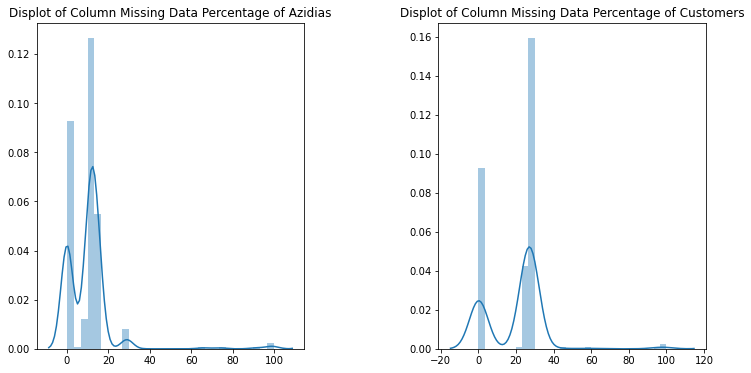

In [8]:
azdias_col_missing = missing_data_report(azdias)
customers_col_missing =missing_data_report(customers)

plt.figure(1 , figsize = (12 ,6)) 
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
sns.distplot(azdias_col_missing , bins = 30)
plt.title("Displot of Column Missing Data Percentage of Azidias")


plt.subplot(1, 2, 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
sns.distplot(customers_col_missing , bins = 30)
plt.title("Displot of Column Missing Data Percentage of Customers")
plt.show()

High missing data proportion might hurt the clustering result while dropping too many attributes might affect the accuracy of algorithms. We expected 30% would be a proper threshold to clean the datasets. 

In [9]:
customers_col_missing.head(10)

ALTER_KIND4     99.876860
ALTER_KIND3     99.334732
ALTER_KIND2     97.338927
ALTER_KIND1     93.860748
KK_KUNDENTYP    58.406382
EXTSEL992       44.498883
KBA05_KW1       29.209192
KBA05_MOD1      29.209192
KBA05_MOTOR     29.209192
KBA05_MOD4      29.209192
dtype: float64

In [10]:
azdias_col_missing.head(10)

ALTER_KIND4                  99.864792
ALTER_KIND3                  99.307691
ALTER_KIND2                  96.690047
ALTER_KIND1                  90.904837
EXTSEL992                    73.399639
KK_KUNDENTYP                 65.596749
ALTERSKATEGORIE_FEIN         29.504130
D19_LETZTER_KAUF_BRANCHE     28.849522
D19_LOTTO                    28.849522
D19_VERSI_ONLINE_QUOTE_12    28.849522
dtype: float64

As we can see in the series, ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4 have more than 90% missing values. Most attributes (approximately 98% ) have less than 30% missing values

Next, plot the distributions of row missing data.

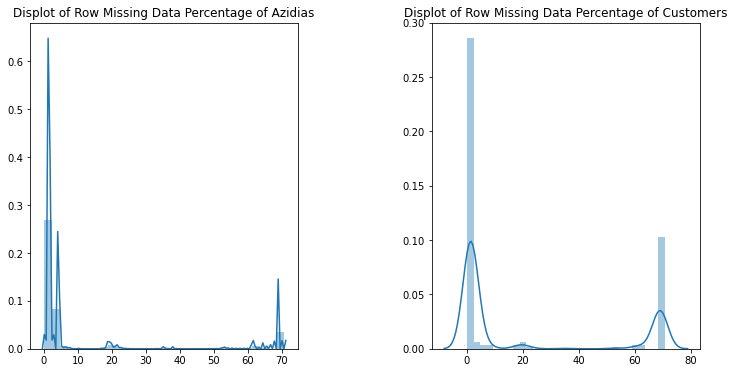

In [11]:
azdias_row_missing = missing_data_report(azdias, columns = False)
customers_row_missing =missing_data_report(customers, columns = False)

plt.figure(1 , figsize = (12 ,6)) 
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
sns.distplot(azdias_row_missing , bins = 30)
plt.title("Displot of Row Missing Data Percentage of Azidias")


plt.subplot(1, 2, 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
sns.distplot(customers_row_missing , bins = 30)
plt.title("Displot of Row Missing Data Percentage of Customers")
plt.show()

In [12]:
azdias_row_missing.head(10)

55664     70.765027
537799    70.765027
350182    70.765027
373501    70.765027
826869    70.765027
739769    70.491803
475330    70.491803
5099      70.491803
140317    70.491803
522174    70.491803
dtype: float64

In [13]:
customers_row_missing.head(10)

84107     70.765027
74012     70.765027
89983     70.765027
176782    69.672131
95825     69.125683
138150    69.125683
138162    69.125683
138160    69.125683
138159    69.125683
138158    69.125683
dtype: float64

As showing in the plots, we expected 30% would be a proper threshold to clean the datasets as well.

In [14]:
def missing_data_drop(dataset, dataset_col_missing, dataset_row_missing, threshold):
    '''
    Drop column and row values with high proportion of null values
    :param dataset: a dataframe of data
    :param dataset_col_missing: missing data distribution of columns 
    :param dataset_row_missing: missing data distribution of rows 
    :param threshold: the critical value of keeping null values
    :return: a dataframe without high proportion of null values
    '''
    col_threshold = dataset_col_missing[dataset_col_missing>100-threshold].index
    row_threshold = dataset_row_missing[dataset_row_missing>100-threshold].index
    
    dataset.drop(axis=1, columns = col_threshold, inplace = True) # axis={0 or 'index', 1 or 'columns'}, default 0
    dataset.drop(axis=0, index   = row_threshold, inplace = True)

    return dataset


### 0.4 Attribute exploration

In [15]:
# attributes loading
attri_values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header=1, index_col=None)
attri_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1, index_col=None)


In [16]:
attri_values.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [17]:
attri_info.head(10)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [18]:
attri_values.drop("Unnamed: 0",axis=1, inplace=True)

In [19]:
attri_info.drop("Unnamed: 0",axis=1, inplace=True)

Due to the different format of dataframe and excel, there are some NaN values in **Attribute** column and **Description** column in `DIAS Attributes - Values 2017` and in **Information level** column in `DIAS Information Levels - Attributes 2017`. We would like to replace these NaN values.

In [20]:
attri_values[['Attribute','Description']] = attri_values[['Attribute','Description']].ffill()
attri_values.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [21]:
attri_info['Information level'] = attri_info['Information level'].ffill()
attri_info.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,Person,FINANZ_SPARER,financial typology: money saver,NaN
6,Person,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,Person,FINANZ_ANLEGER,financial typology: investor,NaN
8,Person,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,Person,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [22]:
attri_info['Information level'][attri_info['Information level'].isnull()]

0    NaN
Name: Information level, dtype: object

In [23]:
attri_info['Information level'].replace({np.nan: "Person"},inplace=True)

In [24]:
attri_values.describe()

,Attribute,Description,Value,Meaning
count,2258,2258,2258,2247
unique,314,316,102,538
top,CAMEO_DEU_2015,- on grid level -,1,unknown
freq,44,238,304,232


In [25]:
attri_info.describe()

,Information level,Attribute,Description,Additional notes
count,313,313,313,20
unique,10,313,310,13
top,PLZ8,KBA13_KRSSEG_KLEIN,share of other cars within the PLZ8,modelled on different AZ DIAS data
freq,114,1,2,5


In [26]:
print('DIAS Attributes shape: ', attri_values.shape)
print('DIAS Information Levels shape: ', attri_info.shape)

DIAS Attributes shape:  (2258, 4)
DIAS Information Levels shape:  (313, 4)


**Process string data to numerical ones:**

From the information in Data Description section, we know that there are some attributes of string type. We need to convert them to numerical data.

The idea was got from this website: https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/

In [28]:
# the string type of attrbutes
azdias_string = azdias.dtypes[azdias.dtypes=="object"]
azdias_string

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

In [29]:
customers_string = customers.dtypes[customers.dtypes=="object"]
customers_string

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

In [30]:
string_list = set(azdias_string.index) | set(customers_string.index)
string_list

{'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ'}

In [31]:
# solve the warining messsage as loading the datasets
# column 18 and 19 are of mixed types of data

def mixed_valued_data(dataset, attribute):
    '''
    Replace miss valued "X" and "XX" in certain attributes
    :param dataset: datafrmae of data
    :param attribute: the attribute which has mixed values problem

    '''
    dataset[attribute].replace({"X": np.nan, "XX": np.nan},inplace=True)
    return


In [32]:
for i in ["CAMEO_DEU_2015", "CAMEO_DEUG_2015","CAMEO_INTL_2015"]:
    mixed_valued_data(azdias, i)
    mixed_valued_data(customers, i)

In [33]:
def covert_dtype(dataset, attribute):
    '''
    Convert certain attributes to float data types
    :param dataset: datafrmae of data
    :param attribute: the attribute which has mixed values problem

    '''    
    dataset[attribute] = dataset[attribute].astype(float)
    return

In [34]:
for i in ["CAMEO_DEUG_2015","CAMEO_INTL_2015"]:
    covert_dtype(azdias, i)
    covert_dtype(customers, i)

In [35]:
# drop the converted columns
string_list=string_list.difference({"CAMEO_DEUG_2015"})#,"CAMEO_INTL_2015"})
string_list

{'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ'}

For the remaining attributes, we would like to replace the NaN values with the most frequently occurring values.

In [36]:
def missing_data_replace(dataset, string_list):
    '''
    For the arttributes of string data type, replace the NaN values with the most frequently occurring values
    :param dataset: dataframe
    :param string_list: arttributes of string data type
    
    '''
    
    for i in string_list:
        if i in dataset.columns:
            mode = dataset[i].mode()
            dataset[i].replace({np.nan: mode.values}, inplace=True)
            print("Replaced: ",i)
    return

Convert string type attributes to numerical data:

In [37]:
from sklearn import preprocessing

# rmk: please check if there are any NaN values before running the function
def convert_to_numerical(dataset, string_list):
    '''
    Convert the string data to numerical data
    :param dataset: dataframe
    :param string_list: arttributes of string data type
    
    '''
    le = preprocessing.LabelEncoder()
    for i in string_list:
        if i in dataset.columns:
            dataset[i] = le.fit_transform(dataset[i])
            print("Converted: ",i)
    return


In [38]:
# fill the remaining NaN values with median

def fill_na(dataset):
    '''
    For the remaining data, replace the NaN values with the median
    :param dataset: dataframe
    :param string_list: arttributes of string data type
    
    '''
    for i in dataset.columns:
        dataset[i].fillna(dataset[i].median(), inplace=True)
    return

### 0.5 Correlation among the features

We want to calculate the correlations among features and drop out highly correlated ones.

In [39]:
# the correlation matrix of data

azdias_corr = azdias.corr()
customer_corr = customers.corr()

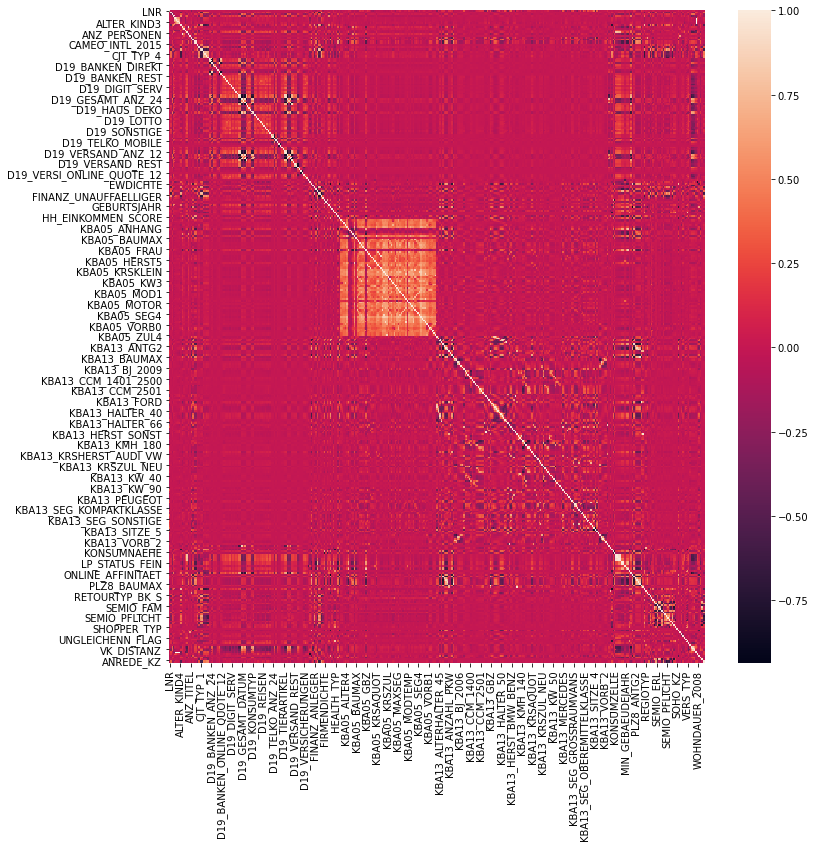

In [40]:
plt.figure(figsize=(12,12))
sns.heatmap(azdias_corr)
plt.show()

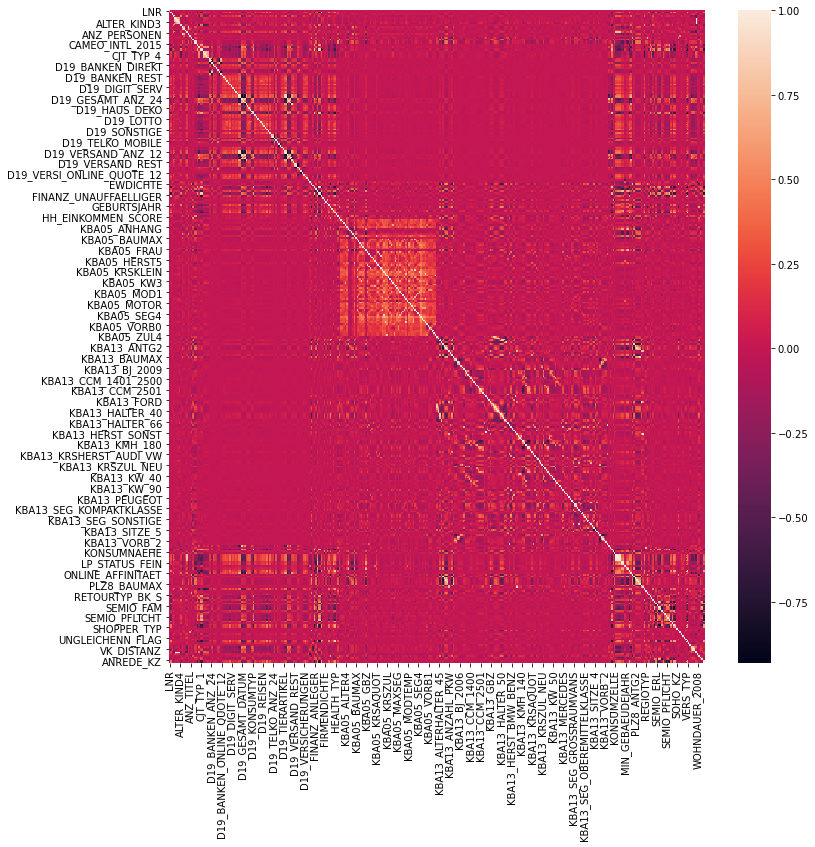

In [41]:
plt.figure(figsize=(12,12))
sns.heatmap(customer_corr)
plt.show()

In [40]:
def high_abs_corr_features(dataset, threshold):
    '''
    Identify highly correlated attributes
    :param dataset: dataframe
    :param threshold: the critical value of high correlation
    :return high_corr_features: highly correlated attributes
    
    '''
    corr_matrix = dataset.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
   
    # find features with correlations bigger than threshold
    high_corr_features = [col for col in upper_limit.columns if any(upper_limit[col] > threshold)]

    return high_corr_features


### 0.6 Data standardization

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale(dataset):
    '''
    Scale the data to speed up the modeling process
    :param dataset: dataframe
    :return scaled: dataframe of scaled data
    
    '''
    scaler =  MinMaxScaler()
    fit = scaler.fit_transform(dataset)
    scaled = pd.DataFrame(fit,columns= dataset.columns)
    return scaled


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Data preprocessing

In [42]:
print("Pre-check: ")
print("The shape of AZIDIAS:", azdias.shape)
print("The shape of CUSTOMERS:", customers.shape)

for i in string_list:
    if i in azdias.columns:
        print("Unique values of "+str(i)+" in AZIDIAS:", azdias[i].unique(),"\n")
    if i in customers.columns:
        print("Unique values of "+str(i)+" in CUSTOMERS:", customers[i].unique(),"\n")

Pre-check: 
The shape of AZIDIAS: (891221, 366)
The shape of CUSTOMERS: (191652, 366)
Unique values of OST_WEST_KZ in AZIDIAS: [nan 'W' 'O'] 

Unique values of OST_WEST_KZ in CUSTOMERS: ['W' nan 'O'] 

Unique values of CAMEO_INTL_2015 in AZIDIAS: [nan 51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52.
 35. 45. 44. 32.] 

Unique values of CAMEO_INTL_2015 in CUSTOMERS: [13. nan 34. 24. 41. 23. 15. 55. 14. 22. 43. 51. 33. 25. 44. 54. 32. 12.
 35. 31. 45. 52.] 

Unique values of D19_LETZTER_KAUF_BRANCHE in AZIDIAS: [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SE

In [43]:
# drop some of the NaN values in columns and rows
azdias_row_missing = missing_data_report(azdias, columns = False)
azdias_col_missing = missing_data_report(azdias, columns = True)

customers_row_missing =missing_data_report(customers, columns = False)
customers_col_missing =missing_data_report(customers, columns = True)

azdias_clean = missing_data_drop(azdias,azdias_col_missing,azdias_row_missing, 30)
customers_clean = missing_data_drop(customers,customers_col_missing, customers_row_missing, 30)

In [44]:
missing_data_replace(azdias_clean, string_list)
missing_data_replace(customers_clean, string_list)

Replaced:  OST_WEST_KZ
Replaced:  CAMEO_INTL_2015
Replaced:  D19_LETZTER_KAUF_BRANCHE
Replaced:  CAMEO_DEU_2015
Replaced:  EINGEFUEGT_AM
Replaced:  OST_WEST_KZ
Replaced:  CAMEO_INTL_2015
Replaced:  D19_LETZTER_KAUF_BRANCHE
Replaced:  CAMEO_DEU_2015
Replaced:  EINGEFUEGT_AM


In [45]:
# rmk: please check if there are any NaN values before running the function

print("AZDIAS: ","\n",azdias_clean[azdias_string.index.tolist()].isnull().any(), "\n")
print("CUSTOMERS: ","\n",customers_clean[customers_string.index.tolist()].isnull().any())


AZDIAS:  
 CAMEO_DEU_2015              False
CAMEO_DEUG_2015              True
CAMEO_INTL_2015             False
D19_LETZTER_KAUF_BRANCHE    False
EINGEFUEGT_AM               False
OST_WEST_KZ                 False
dtype: bool 

CUSTOMERS:  
 CAMEO_DEU_2015              False
CAMEO_DEUG_2015              True
CAMEO_INTL_2015             False
D19_LETZTER_KAUF_BRANCHE    False
EINGEFUEGT_AM               False
OST_WEST_KZ                 False
dtype: bool


In [46]:
azdias_clean[string_list]

,OST_WEST_KZ,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,CAMEO_DEU_2015,EINGEFUEGT_AM
0,W,51.0,D19_UNBEKANNT,6B,1992-02-10 00:00:00
1,W,51.0,D19_UNBEKANNT,8A,1992-02-10 00:00:00
2,W,24.0,D19_UNBEKANNT,4C,1992-02-12 00:00:00
3,W,12.0,D19_UNBEKANNT,2A,1997-04-21 00:00:00
4,W,43.0,D19_SCHUHE,6B,1992-02-12 00:00:00
...,...,...,...,...,...
891216,W,41.0,D19_HAUS_DEKO,7A,1992-02-10 00:00:00
891217,W,51.0,D19_UNBEKANNT,9D,1992-02-10 00:00:00
891218,W,24.0,D19_BEKLEIDUNG_GEH,4C,1992-02-10 00:00:00
891219,W,51.0,D19_UNBEKANNT,9D,1992-02-12 00:00:00


In [47]:
convert_to_numerical(azdias_clean, string_list)
convert_to_numerical(customers_clean, string_list)

Converted:  OST_WEST_KZ
Converted:  CAMEO_INTL_2015
Converted:  D19_LETZTER_KAUF_BRANCHE
Converted:  CAMEO_DEU_2015
Converted:  EINGEFUEGT_AM
Converted:  OST_WEST_KZ
Converted:  CAMEO_INTL_2015
Converted:  D19_LETZTER_KAUF_BRANCHE
Converted:  CAMEO_DEU_2015
Converted:  EINGEFUEGT_AM


In [48]:
# drop highly correlated features
high_corr_features = high_abs_corr_features(azdias, threshold=0.9)
print("The number of highly correlated features:",len(high_corr_features))
azdias_clean.drop(high_corr_features, axis=1, inplace=True)
customers_clean.drop(high_corr_features, axis=1, inplace=True)

The number of highly correlated features: 26


In [49]:
fill_na(azdias_clean)
fill_na(customers_clean)

Check missing values:

In [50]:
azdias_clean.columns[azdias_clean.isnull().any()]

Index([], dtype='object')

In [51]:
customers_clean.columns[customers_clean.isnull().any()]

Index([], dtype='object')

Standardlize data by MinMaxScaler:

In [52]:
azdias_scaled = scale(azdias_clean)
customers_scaled = scale(customers_clean)

In [53]:
print("After-check: ")
print("The shape of AZIDIAS:", azdias_scaled.shape)
print("The shape of CUSTOMERS:", customers_scaled.shape)

for i in string_list:
    if i in azdias_scaled.columns:
        print("Unique values of "+str(i)+" in AZIDIAS:", azdias_scaled[i].unique(),"\n")
    if i in customers_scaled.columns:
        print("Unique values of "+str(i)+" in CUSTOMERS:", customers_scaled[i].unique(),"\n")

After-check: 
The shape of AZIDIAS: (891204, 335)
The shape of CUSTOMERS: (191649, 336)
Unique values of OST_WEST_KZ in AZIDIAS: [1. 0.] 

Unique values of OST_WEST_KZ in CUSTOMERS: [1. 0.] 

Unique values of D19_LETZTER_KAUF_BRANCHE in AZIDIAS: [0.88235294 0.70588235 0.32352941 0.5        0.97058824 0.73529412
 0.02941176 0.29411765 0.41176471 0.23529412 0.94117647 0.91176471
 0.82352941 0.         0.08823529 0.35294118 0.52941176 0.44117647
 0.14705882 0.67647059 0.79411765 0.64705882 0.11764706 0.76470588
 0.58823529 0.26470588 0.55882353 0.61764706 0.85294118 0.47058824
 0.20588235 1.         0.38235294 0.17647059 0.05882353] 

Unique values of D19_LETZTER_KAUF_BRANCHE in CUSTOMERS: [0.88235294 0.02941176 0.58823529 0.70588235 0.23529412 0.29411765
 0.73529412 0.76470588 0.94117647 0.79411765 0.97058824 0.44117647
 0.32352941 0.64705882 0.05882353 0.91176471 0.14705882 0.35294118
 0.11764706 0.82352941 0.67647059 0.         0.47058824 0.08823529
 0.52941176 0.38235294 0.41176471 0.

In [54]:
azdias.to_pickle('./azidias_cleaned.pk')
customers.to_pickle('./customers_cleaned.pk')

### 1.2 PCA

In [55]:
# the number of total attributes
print("The number of original features: ", azdias_scaled.shape[1])

The number of original features:  335


In [56]:
from sklearn.decomposition import PCA

def PCA_model(data_scaled, component_num=None):
    pca = PCA(component_num)
    pca_fit = pca.fit(data_scaled)
    pca_transform = pd.DataFrame(pca.transform(data_scaled))
    return pca_fit, pca_transform 

In [57]:
azdias_pca_fit, azdias_pca_transform = PCA_model(azdias_scaled)

Text(0.5, 1.0, 'Explained Variance Per Component')

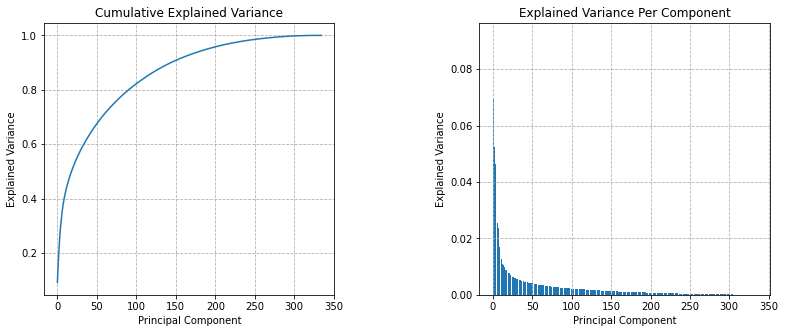

In [58]:
values=azdias_pca_fit.explained_variance_ratio_
num_components=np.arange(len(values))

plt.figure(1 , figsize = (13 ,5)) 
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(values))
plt.grid(ls='--', which='major')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title('Cumulative Explained Variance')
plt.subplot(1, 2, 2)

plt.bar(num_components,values)
plt.grid(ls='--', which='major')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title('Explained Variance Per Component')

Cumulative explained variance with the number of principal components is showed above. We can see that around 150 components explain 90% of the variance. And after 150 components, the variance explained by each component is less significant.

In [230]:
# select a value for the number of top components
component_num = 150

# Calculate the explained variance for the top n principal components
np.cumsum(values)[component_num]
print('The explained variance for the top {} principal components: %.2f%%'.format(component_num) 
      % (np.cumsum(values)[component_num]*100))

The explained variance for the top 150 principal components: 90.82%


So, we will choose 150 as the number of top n-components.

We will define a function `display_component` to help display the features of a specific PCA compontent. This fuction refers to the Population Segmentation case in Udacity Machine Learning Nanodegree. 

Ref: https://github.com/udacity/ML_SageMaker_Studies/blob/master/Population_Segmentation/Pop_Segmentation_Solution.ipynb

In [258]:
def display_component(v, features_list, component, n_weights=10):
    '''
    Examine the makeup of each PCA component based on the weightings of the original features 
    that are included in the component
    #param v: dataframe
    #param features_list: features in the dataframe
    #param component: ordinal number of the specific component
    #param n_weights: top n features of the component
    #return sorted_weight_data['features']: top weighted features of the component
    
    '''
 
    # get the list of weights from a row in v, dataframe
    v_1_row = v[component-1]

    # match weights to features in scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1_row, features_list)), columns=['Weight', 'Attribute'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_Weight']=comps['Weight'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_Weight', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="Weight", 
                   y="Attribute", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component))
    
    plt.show()
    return sorted_weight_data

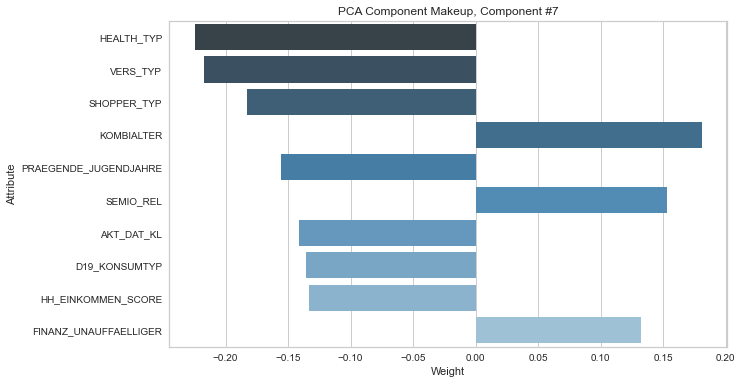

,Weight,Attribute,abs_Weight
101,-0.224771,HEALTH_TYP,0.224771
323,-0.217063,VERS_TYP,0.217063
315,-0.182910,SHOPPER_TYP,0.182910
282,0.181077,KOMBIALTER,0.181077
294,-0.155564,PRAEGENDE_JUGENDJAHRE,0.155564
311,0.153441,SEMIO_REL,0.153441
2,-0.141049,AKT_DAT_KL,0.141049
49,-0.136026,D19_KONSUMTYP,0.136026
103,-0.133506,HH_EINKOMMEN_SCORE,0.133506
91,0.132701,FINANZ_UNAUFFAELLIGER,0.132701


In [259]:
# for example
display_component(v=azdias_pca_fit.components_, features_list=azdias.columns, component=7, n_weights=10)

In [63]:
azdias_pca_fit_top, azdias_pca_transformed_top  = PCA_model(azdias_scaled, component_num)
customers_pca_fit_top, customers_pca_transformed_top  = PCA_model(customers_scaled, component_num)

### 1.3 K-Means clustering

K-means clustering is a type of unsupervised learning methods, which is used on unlabeled data. The goal of K-Means algorithm is to divide data into proper groups based on similarity.

We will use K-Means clustering method on the PCA data to cluster population data into different segments. Before applying this algorithm, we need to find out the ideal number of clusters by Elbow method.

**Elbow method**

This method help us select the number of clusters to minimize the variation within each cluster.

In [64]:
from sklearn.cluster import KMeans

def elbow_method(dataset, k_begin, k_end, step):
    '''
    Identity the optimal number of clusters
    #param: dataframe
    #param k_begin: the begin of loop
    #param k_end: the end of loop
    #param step: the step of loop
    #return inertia: the values of inertia
    
    '''
    inertias = []
    for i in range(k_begin, k_end, step):
        model = KMeans(i).fit(dataset)
        inertias.append(model.inertia_)

    plt.title("Elbow Method")
    plt.plot(range(k_begin, k_end), inertias, '-o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    return inertias

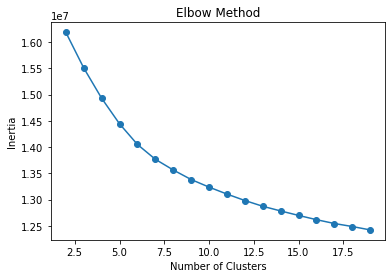

In [139]:
elbow_method(azdias_pca_transformed_top, k_begin=2, k_end=20, step=1)

In the plot of Distortion score versus K, we can see that the sum of sqaured error decreasing. At around 9 clusters, the decreasing speed significantly reduced. This is visible as an elbow. The yellowbrick package offers a quick way to identify the value of K. K=9 is also justified by yellobrick method. Therefore, we choose 9 as the number of clusters.

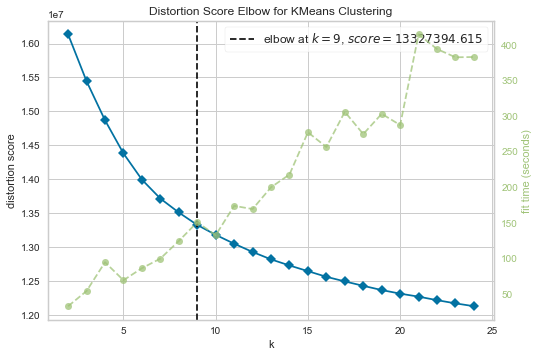

D:\anaconda\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001BF267EFBE0>,
                 estimator=KMeans(n_clusters=24), k=None)

In [65]:
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

kelbow_visualizer (KMeans(), azdias_pca_transformed_top, k=(2,25))

**K-Means Algorithm**

In [68]:
n_clusters=9
kmeans = KMeans(n_clusters)

In [69]:
def k_clustering(pac_transform, n_clusters):
    '''
    Build KMeans model
    #param pac_transform: pca model
    #param n_clusters: the optimal number of clusters
    #return k_fit: KMeans fitted model
    #return k_predict: KMeans model predicts
    #return k_centroids: the centroids of clusters

    '''
    k_fit = kmeans.fit(pac_transform)
    k_predict = k_fit.predict(pac_transform)
    k_centroids = k_fit.cluster_centers_
    
    return k_fit, k_predict, k_centroids


In [70]:
azdias_k_fit, azdias_k_predict, azdias_k_centroids = k_clustering(azdias_pca_transformed_top, n_clusters)
customers_k_fit, customers_k_predict, customers_k_centroids = k_clustering(customers_pca_transformed_top, n_clusters)


In [71]:
azdias_k_predict

array([2, 8, 8, ..., 5, 6, 7])

In [72]:
customers_k_predict

array([1, 1, 8, ..., 1, 6, 5])

### 1.4 Clusters Interpretation

In [73]:
azdias_clusters = pd.Series(azdias_k_predict).value_counts()
customers_clusters = pd.Series(customers_k_predict).value_counts()

In [74]:
azdias_clusters

7    130516
1    124340
4    121135
5    118575
8    118403
6    104057
2     89466
0     69926
3     14786
dtype: int64

In [75]:
customers_clusters

3    46891
1    29477
0    22637
8    18306
5    16889
7    15947
6    15692
2    14840
4    10970
dtype: int64

In [76]:
clusters = pd.concat([azdias_clusters, customers_clusters], keys=azdias_clusters.index, axis=1)
clusters.columns= ["azdias clusters count","custmers clusters count"]
clusters

,azdias clusters count,custmers clusters count
0,69926,22637
1,124340,29477
2,89466,14840
3,14786,46891
4,121135,10970
5,118575,16889
6,104057,15692
7,130516,15947
8,118403,18306


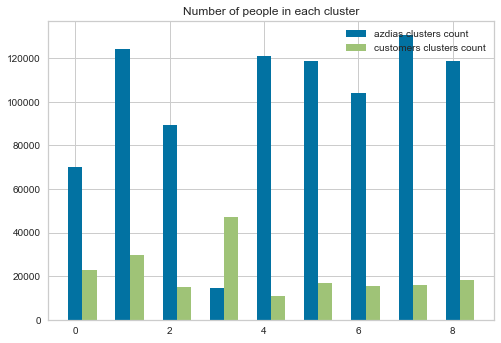

In [221]:
width = 0.3 

plt.bar(clusters.index,clusters.iloc[:,0],width, label="azdias clusters count")
plt.bar(clusters.index+width,clusters.iloc[:,1],width, label="customers clusters count")
plt.title("Number of people in each cluster")
plt.legend()

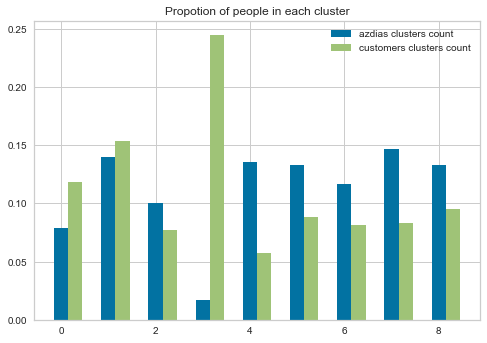

In [77]:
plt.bar(clusters.index,clusters.iloc[:,0]/clusters.iloc[:,0].sum(), width, label="azdias clusters count")
plt.bar(clusters.index+width,clusters.iloc[:,1]/clusters.iloc[:,1].sum(), width, label="customers clusters count")
plt.title("Proportion of people in each cluster")
plt.legend()

From the graph, we can see the distributions of Azdias clusters and Customers clusters vary. 

Note that if we regard the features of mail-order company's customers to be similar with the country's population, then the distribution of customers clusters should be similar with that of Azdias clusters. 

We want to explore the special characteristics of customers. So, we should pay more attention to the mismatches.If there are particular clusters of the population are interested in the company's products, then we should see a mismatch from the one to  others.For example, compared to the population, a cluster has a higher proportion in customers. In this circumstance, we could expect it is the characteristics of target customers. Conversely, if a cluster has a lower proportion, we could expect it is not belong to the target customers.

Therefore, we are super interested in clusters which have higher proportions in customers than in Azdias.

From the graph above, we can see that cluster 3 in customers has visibly higher proportion. Cluster 4 has
higher proportions in Azdias.

In [79]:
def cluster_description(cluster, kmeans):

    centroid = kmeans.cluster_centers_[cluster]
    centroid_sort = pd.Series(centroid, name= f"cluster_{cluster}").sort_values(ascending=False)

    return centroid_sort

In [285]:
cluster_num=3
cluster_description(cluster_num, customers_k_fit)

3     0.143810
7     0.103453
4     0.062901
26    0.017965
27    0.017110
        ...   
6    -0.061205
2    -0.138337
5    -0.203261
1    -0.317997
0    -2.759458
Name: cluster_3, Length: 150, dtype: float64

In cluster 3, PCA 3 and PCA 7 are significant.

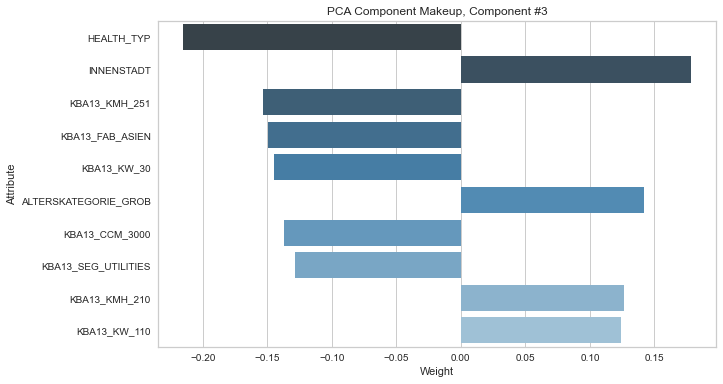

In [281]:
component_3 = display_component(v=customers_pca_fit_top.components_, features_list=customers.columns, component=3, n_weights=10)


By checking the attribute information, we can get:

In [282]:
component_3_info=pd.DataFrame(columns=attri_info.columns)
for i in component_3["Attribute"]:
    try:
        component_3_info=component_3_info.append(attri_info[attri_info["Attribute"]==i])
    except:
        pass
component_3_info.set_index("Attribute").join(component_3.set_index("Attribute"),how="inner").sort_values('abs_Weight', ascending=False)

,Information level,Description,Additional notes,Weight,abs_Weight
Attribute,,,,,
HEALTH_TYP,Person,health typology,in cooperation with Kantar TNS; the informatio...,-0.215059,0.215059
INNENSTADT,Postcode,distance to the city centre,NaN,0.178075,0.178075
KBA13_KMH_251,PLZ8,share of cars with a greater max speed than 25...,NaN,-0.153378,0.153378
KBA13_FAB_ASIEN,PLZ8,share of other Asian Manufacturers within the ...,NaN,-0.149211,0.149211
KBA13_KW_30,PLZ8,share of cars up to 30 KW engine power - PLZ8,NaN,-0.144736,0.144736
ALTERSKATEGORIE_GROB,Person,age through prename analysis,modelled on millions of first name-age-referen...,0.142106,0.142106
KBA13_SEG_UTILITIES,PLZ8,share of MUVs/SUVs within the PLZ8,NaN,-0.128712,0.128712
KBA13_KW_110,PLZ8,share of cars with an engine power between 91 ...,NaN,0.124256,0.124256


In PCA 3, health typology and the distance to the city center account for large weights.

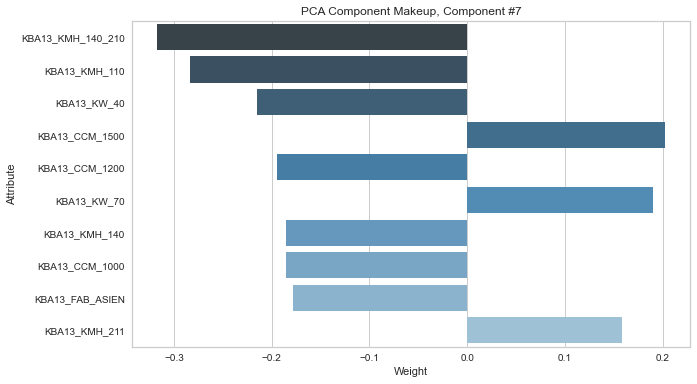

In [283]:
component_7 = display_component(v=customers_pca_fit_top.components_, features_list=customers.columns, component=7, n_weights=10)

By checking the attribute information, we can get:

In [284]:
component_7_info=pd.DataFrame(columns=attri_info.columns)
for i in component_7["Attribute"]:
    try:
        component_7_info=component_7_info.append(attri_info[attri_info["Attribute"]==i])
    except:
        pass
component_7_info.set_index("Attribute").join(component_7.set_index("Attribute"),how="inner").sort_values('abs_Weight', ascending=False)

,Information level,Description,Additional notes,Weight,abs_Weight
Attribute,,,,,
KBA13_KMH_140_210,PLZ8,share of cars with max speed between 140 and 2...,NaN,-0.316862,0.316862
KBA13_KMH_110,PLZ8,share of cars with max speed 110 km/h within t...,NaN,-0.283444,0.283444
KBA13_KW_40,PLZ8,share of cars with an engine power between 31 ...,NaN,-0.214748,0.214748
KBA13_CCM_1500,PLZ8,share of cars with 1400ccm to 1499ccm within t...,NaN,0.202061,0.202061
KBA13_CCM_1200,PLZ8,share of cars with less than 1000ccm within th...,NaN,-0.194539,0.194539
KBA13_KW_70,PLZ8,share of cars with an engine power between 61 ...,NaN,0.189594,0.189594
KBA13_KMH_140,PLZ8,share of cars with max speed between 110 km/h ...,NaN,-0.185794,0.185794
KBA13_CCM_1000,PLZ8,share of cars with less than 1000ccm within th...,NaN,-0.185789,0.185789
KBA13_FAB_ASIEN,PLZ8,share of other Asian Manufacturers within the ...,NaN,-0.178284,0.178284


In PCA 7, the types (speed limitation, engine power limitation,CCM) of cars account for large proportion.

In conclusion, the health conditions of customers, the distance to the city center, the types (speed limitation, engine power limitation,CCM) of cars could largely affect their response to marketing campaign. 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [3]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [88]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [89]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


### 2.1 Data pre-processing

In [90]:
mailout_string = mailout_train.dtypes[mailout_train.dtypes=="object"].index
mailout_string

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [91]:
print("Pre-check: ")
print("The shape of MAILOUT:", mailout_train.shape)

for i in mailout_string:
    if i in mailout_train.columns:
        print("Unique values of "+str(i)+" in MAILOUT:", mailout_train[i].unique(),"\n")

Pre-check: 
The shape of MAILOUT: (42962, 367)
Unique values of CAMEO_DEU_2015 in MAILOUT: ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B'
 '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E'
 '2A' '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A'
 '5F' '1B' 'XX'] 

Unique values of CAMEO_DEUG_2015 in MAILOUT: [5.0 2.0 7.0 4.0 nan 3.0 6.0 1.0 8.0 9.0 '4' '6' '2' '9' '8' '7' '3' '1'
 '5' 'X'] 

Unique values of CAMEO_INTL_2015 in MAILOUT: [34.0 32.0 14.0 41.0 24.0 33.0 nan 25.0 31.0 22.0 43.0 13.0 55.0 23.0 54.0
 51.0 45.0 12.0 44.0 35.0 15.0 52.0 '23' '44' '14' '55' '51' '45' '43'
 '22' '54' '24' '25' '13' '12' '35' '33' '41' '15' '52' '31' '32' '34'
 'XX'] 

Unique values of D19_LETZTER_KAUF_BRANCHE in MAILOUT: ['D19_UNBEKANNT' 'D19_TELKO_MOBILE' 'D19_LEBENSMITTEL'
 'D19_BEKLEIDUNG_GEH' 'D19_BUCH_CD' nan 'D19_NAHRUNGSERGAENZUNG'
 'D19_SCHUHE' 'D19_SONSTIGE' 'D19_HAUS_DEKO' 'D19_FREIZEIT' 'D19_ENERGIE'
 'D19_VOLLSORTIMENT' 'D1

In [92]:
# replace miss valued data
for i in ["CAMEO_DEU_2015", "CAMEO_DEUG_2015","CAMEO_INTL_2015"]:
    mixed_valued_data(mailout_train,i)
    print(mailout_train[i].unique())


['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B'
 '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E'
 '2A' '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A'
 '5F' '1B']
[5.0 2.0 7.0 4.0 nan 3.0 6.0 1.0 8.0 9.0 '4' '6' '2' '9' '8' '7' '3' '1'
 '5']
[34.0 32.0 14.0 41.0 24.0 33.0 nan 25.0 31.0 22.0 43.0 13.0 55.0 23.0 54.0
 51.0 45.0 12.0 44.0 35.0 15.0 52.0 '23' '44' '14' '55' '51' '45' '43'
 '22' '54' '24' '25' '13' '12' '35' '33' '41' '15' '52' '31' '32' '34']


In [93]:
for i in ["CAMEO_DEUG_2015","CAMEO_INTL_2015"]:
    covert_dtype(mailout_train, i)

In [94]:
# drop the converted columns
mailout_string = set(mailout_string).difference({"CAMEO_DEUG_2015","CAMEO_INTL_2015"})
mailout_string

{'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'}

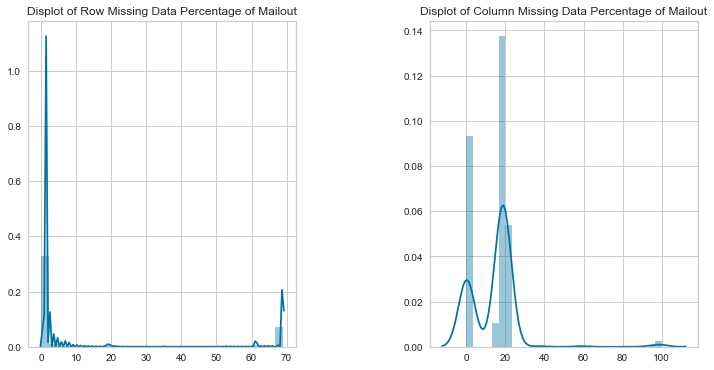

In [95]:
mailout_row_missing = missing_data_report(mailout_train, columns = False)
mailout_col_missing = missing_data_report(mailout_train, columns = True)

plt.figure(1 , figsize = (12 ,6)) 
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
sns.distplot(mailout_row_missing , bins = 30)
plt.title("Displot of Row Missing Data Percentage of Mailout")


plt.subplot(1, 2, 2)
plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
sns.distplot(mailout_col_missing , bins = 30)
plt.title("Displot of Column Missing Data Percentage of Mailout")
plt.show()

In [96]:
# drop some of the NaN values in columns and rows
mailout_clean = missing_data_drop(mailout_train ,mailout_col_missing,mailout_row_missing, 30)

In [97]:
missing_data_replace(mailout_clean, mailout_string)

def missing_data_replace(dataset, string_list):
    for i in string_list:
        if i in dataset.columns:
            mode = dataset[i].mode()
            dataset[i].replace({np.nan: mode.values}, inplace=True)
            print("Replaced: ",i)
    return

Replaced:  OST_WEST_KZ
Replaced:  EINGEFUEGT_AM
Replaced:  D19_LETZTER_KAUF_BRANCHE
Replaced:  CAMEO_DEU_2015


In [98]:
# rmk: please check if there are any NaN values before running the function
print("MAILOUT: ","\n",mailout_clean[list(mailout_string)].isnull().any(), "\n")


MAILOUT:  
 OST_WEST_KZ                 False
EINGEFUEGT_AM               False
D19_LETZTER_KAUF_BRANCHE    False
CAMEO_DEU_2015              False
dtype: bool 



In [99]:
convert_to_numerical(mailout_clean, mailout_string)

Converted:  OST_WEST_KZ
Converted:  EINGEFUEGT_AM
Converted:  D19_LETZTER_KAUF_BRANCHE
Converted:  CAMEO_DEU_2015


In [100]:
# drop highly correlated features
high_corr_features_m = high_abs_corr_features(mailout_train, threshold=0.9)
mailout_clean.drop(high_corr_features_m, axis=1, inplace=True)

# fill NaN with median
fill_na(mailout_clean)

In [101]:
# Check missing values:
mailout_clean.columns[mailout_clean.isnull().any()]

Index([], dtype='object')

In [102]:
# data standardlization
mailout_scaled = scale(mailout_clean)

In [103]:
print("After-check: ")
print("The shape of MAILOUT:", mailout_scaled.shape)

for i in string_list:
    if i in mailout_scaled.columns:
        print("Unique values of "+str(i)+" in MAILOUT:", mailout_scaled[i].unique(),"\n")

After-check: 
The shape of MAILOUT: (42962, 339)
Unique values of OST_WEST_KZ in MAILOUT: [1. 0.] 

Unique values of D19_LETZTER_KAUF_BRANCHE in MAILOUT: [0.88235294 0.79411765 0.52941176 0.11764706 0.23529412 0.58823529
 0.70588235 0.73529412 0.44117647 0.35294118 0.32352941 0.97058824
 0.08823529 0.94117647 0.47058824 0.76470588 0.29411765 0.14705882
 1.         0.41176471 0.38235294 0.         0.26470588 0.64705882
 0.67647059 0.02941176 0.91176471 0.82352941 0.17647059 0.05882353
 0.85294118 0.20588235 0.61764706 0.55882353 0.5       ] 

Unique values of CAMEO_DEU_2015 in MAILOUT: [0.48837209 0.44186047 0.18604651 0.72093023 0.34883721 0.46511628
 0.58139535 0.27906977 0.41860465 0.1627907  0.30232558 0.
 0.88372093 0.3255814  0.69767442 0.39534884 0.20930233 0.74418605
 0.97674419 0.81395349 0.51162791 0.8372093  0.25581395 0.65116279
 0.37209302 0.13953488 0.23255814 0.79069767 0.11627907 0.60465116
 0.04651163 0.62790698 0.76744186 0.06976744 0.86046512 0.90697674
 0.93023256 0.

In [104]:
y=mailout_scaled['RESPONSE']
X=mailout_scaled.drop(['RESPONSE', 'LNR'],axis=1)


In [105]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print("Shape of train set: ",X_train.shape)
print("Shape of val set: ", X_val.shape)

Shape of train set:  (34369, 337)
Shape of val set:  (8593, 337)


### 2.2 Evaluation metrics

Note that the Mailout dataset is highly imbalanced. And 98.76% of the response were labeled as 0. This may result in some overfitting towards non-response data. Therefore, we need to carefully choosing metric choice to help us decrease the number of false positives or negatives. 

In order to address this imbalance and evaluate the model at the same time, we would imploy **Area under Receiver Operating Curve (AUROC)** to be the metric.

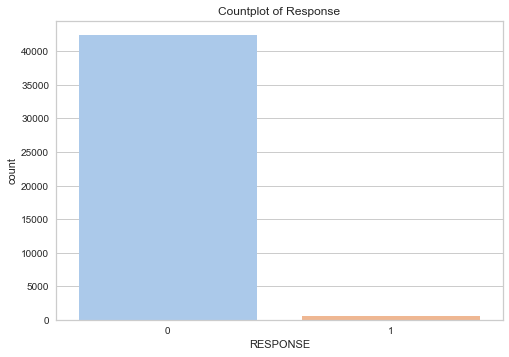

In [106]:
sns.countplot(mailout_train['RESPONSE'] ,data=mailout_train, palette="pastel")
plt.title('Countplot of Response')
plt.show()

In [107]:
from sklearn.metrics import roc_auc_score

### 2.3 Benchmark

We will define a funtion to train the data with different algorithms.

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost

In [109]:
def classifier_result(algo, X_train, X_val, y_train, y_val):
    start = time.time()
    algo = algo.fit(X_train, y_train)    
        
    y_predict = algo.predict_proba(X_val)[:,1]
    
    accuracy = algo.score(X_val, y_val)
    score = roc_auc_score(y_val, y_predict)

    print("Accuracy: ", accuracy)
    print("AUROC score: ", score)    

    end = time.time()
    time_spent = end-start
    print("Training time: %.4f" % time_spent, "seconds")
    return accuracy, score, time_spent

In [110]:
lr = LogisticRegression()
print("Benchmark model:")
lr_accuracy, lr_score, lt_time = classifier_result(lr, X_train, X_val, y_train, y_val)

Benchmark model:
Accuracy:  0.9873152566042127
AUROC score:  0.6737717841246771
Training time: 1.9972 seconds


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2.4 Other Different Models

#### 2.4.1 Decision Tree

In [123]:
dt = DecisionTreeClassifier(random_state=42)
print("Decision tree model:")
dt_accuracy, dt_score, dt_time = classifier_result(dt, X_train, X_val, y_train, y_val)

Decision tree model:
Accuracy:  0.9726521587338531
AUROC score:  0.4937551094558998
Training time: 3.5619 seconds


#### 2.4.2 Randon Forest Classifier

In [122]:
rf = RandomForestClassifier(random_state=42)
print("Random forest model: ")
rf_accuracy, rf_score, rf_time = classifier_result(rf, X_train, X_val, y_train, y_val)

Random forest model: 
Accuracy:  0.9873152566042127
AUROC score:  0.6020382673916146
Training time: 14.5524 seconds


#### 2.4.3 Gradient Boosting Classifier

In [215]:
from sklearn.ensemble import GradientBoostingClassifier
gb_accuracy, gb_score, gb_time = classifier_result(GradientBoostingClassifier(), X_train, X_val, y_train, y_val)

Accuracy:  0.9868497614337252
AUROC score:  0.7550981015532745
Training time: 57.9933 seconds


#### 2.4.4 XGBoost Classifier

In [121]:
xgb = xgboost.XGBClassifier(objective='binary:logistic',random_state=42)
print("XGBosst model: ")
xgb_accuracy, xgb_score, xgb_time = classifier_result(xgb, X_train, X_val, y_train, y_val)

XGBosst model: 


D:\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:52:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.9873152566042127
AUROC score:  0.6711354130170554
Training time: 10.9956 seconds


#### 2.4.5 LGBM Classifier

In [218]:
from lightgbm import LGBMClassifier
lg=LGBMClassifier(boosting_type='gbdt', objective = 'binary',random_state=42)
lg_accuracy, lg_score, lg_time = classifier_result(lg, X_train, X_val, y_train, y_val)

Accuracy:  0.9873152566042127
AUROC score:  0.7072622399854664
Training time: 2.9873 seconds


### 2.5 Fine tuning

Among the three training models with the default hyperparameters, CatBoostClassifier got the highest AUROC score which is approximately 0.709. And LGBMClassifier got the second high score, 0.704. However, training the model with CatBoostClassifier took 24.19 seconds while LGBMClassifer took 2.07 seconds. Therefore, we consider LGBMClassifier to be the best fitted model and will take fine tuning to make it perform better.

We will use GridSearchCV to find the best performed hyperparameters.

In [130]:
# tuning GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold

param_set = {"n_estimators": [10, 50, 100, 200],
              'max_depth': [5, 10, 15, 20],
              'learning_rate': [0.01, 0.1, 0.2, 1]
}

gb_tuning = GradientBoostingClassifier()

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(gb_tuning, param_set, scoring='roc_auc',cv=skf)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 1],
                         'max_depth': [5, 10, 15, 20],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='roc_auc')

In [135]:
best_gb=grid_search.best_estimator_
print("Best score: %0.2f" % grid_search.best_score_)
print("Best parameters set:")
best_gb_parameters = grid_search.best_estimator_.get_params()

for i in param_set:
    print(i, best_gb_parameters[i])

Best score: 0.76
Best parameters set:
n_estimators 10
max_depth 5
learning_rate 0.1


In [479]:
# tuning LGBMClassifer

param_set = {"n_estimators": [10, 100, 500, 1000, 2000],
              'max_depth': [5, 10, 20, 30],
              'learning_rate': [0.01, 0.05, 0.1, 1]
}

lgbm_tuning = LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         n_jobs=-1)

skf = StratifiedKFold(n_splits=5,random_state=42)
grid_search = GridSearchCV(lgbm_tuning, param_set, scoring='roc_auc',cv=skf)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             estimator=LGBMClassifier(objective='binary'),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 1],
                         'max_depth': [5, 10, 20, 30],
                         'n_estimators': [10, 100, 500, 1000, 2000]},
             scoring='roc_auc')

In [790]:

print("Best score: %0.2f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for i in param_set:
    print(i, best_parameters[i])

Best score: 0.77
Best parameters set:
n_estimators 100
max_depth 10
learning_rate 0.01


LGBM classifier has better performence which got 0.77 on AUROC score.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [193]:
mailout_test = pd.read_pickle("Udacity_MAILOUT_052018_TEST.pk")

In [194]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [195]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [196]:
mailout_test_string = mailout_test.dtypes[mailout_test.dtypes=="object"].index
mailout_test_string

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

### 3.1 Data pre-processing

In [197]:
print("Pre-check: ")
print("The shape of MAILOUT test:", mailout_test.shape)

for i in mailout_test_string:
    if i in mailout_test.columns:
        print("Unique values of "+str(i)+" in MAILOUT test:", mailout_test[i].unique(),"\n")

Pre-check: 
The shape of MAILOUT test: (42833, 366)
Unique values of CAMEO_DEU_2015 in MAILOUT test: ['2B' '5A' '7A' '9D' '4E' '6B' '2D' '1D' '7E' '4C' nan '1C' '4A' '5F' '6D'
 '3C' '9B' '6C' '8B' '3D' '5D' '1A' '3A' '7B' '2C' '8A' '6F' '2A' '5B'
 '6E' '5C' '8D' '4D' '8C' '9E' '7C' '9A' '6A' '9C' '1B' '3B' '7D' '1E'
 'XX' '4B' '5E'] 

Unique values of CAMEO_DEUG_2015 in MAILOUT test: ['2' '5' '7' '9' '4' '6' '1' nan '3' '8' 'X' 3.0 4.0 8.0 6.0 2.0 5.0 7.0
 9.0 1.0] 

Unique values of CAMEO_INTL_2015 in MAILOUT test: ['13' '31' '41' '51' '25' '43' '14' '15' '45' '24' nan '22' '35' '44' '34'
 '23' '12' '32' '33' '55' '54' '52' 'XX' 25.0 23.0 41.0 45.0 51.0 14.0
 13.0 24.0 22.0 43.0 54.0 31.0 44.0 52.0 35.0 15.0 32.0 34.0 12.0 55.0
 33.0] 

Unique values of D19_LETZTER_KAUF_BRANCHE in MAILOUT test: ['D19_BEKLEIDUNG_GEH' 'D19_UNBEKANNT' 'D19_LEBENSMITTEL'
 'D19_BANKEN_GROSS' 'D19_SONSTIGE' 'D19_HAUS_DEKO' 'D19_VERSICHERUNGEN'
 'D19_BUCH_CD' 'D19_VERSAND_REST' 'D19_BEKLEIDUNG_REST'
 'D19_VO

In [198]:
# replace miss valued data
for i in ["CAMEO_DEU_2015", "CAMEO_DEUG_2015","CAMEO_INTL_2015"]:
    mixed_valued_data(mailout_test,i)
    print(mailout_test[i].unique())

['2B' '5A' '7A' '9D' '4E' '6B' '2D' '1D' '7E' '4C' nan '1C' '4A' '5F' '6D'
 '3C' '9B' '6C' '8B' '3D' '5D' '1A' '3A' '7B' '2C' '8A' '6F' '2A' '5B'
 '6E' '5C' '8D' '4D' '8C' '9E' '7C' '9A' '6A' '9C' '1B' '3B' '7D' '1E'
 '4B' '5E']
['2' '5' '7' '9' '4' '6' '1' nan '3' '8' 3.0 4.0 8.0 6.0 2.0 5.0 7.0 9.0
 1.0]
['13' '31' '41' '51' '25' '43' '14' '15' '45' '24' nan '22' '35' '44' '34'
 '23' '12' '32' '33' '55' '54' '52' 25.0 23.0 41.0 45.0 51.0 14.0 13.0
 24.0 22.0 43.0 54.0 31.0 44.0 52.0 35.0 15.0 32.0 34.0 12.0 55.0 33.0]


In [199]:
for i in ["CAMEO_DEUG_2015","CAMEO_INTL_2015"]:
    covert_dtype(mailout_test, i)
    
# drop the converted columns
mailout_test_string = set(mailout_test_string).difference({"CAMEO_DEUG_2015","CAMEO_INTL_2015"})
mailout_test_string

{'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'}

In [200]:
mailout_test_row_missing = missing_data_report(mailout_test, columns = False)
mailout_test_col_missing = missing_data_report(mailout_test, columns = True)

# drop some of the NaN values in columns and rows
mailout_test_clean = missing_data_drop(mailout_test ,mailout_test_col_missing, mailout_test_row_missing, 28)

missing_data_replace(mailout_test_clean, mailout_test_string)

# rmk: please check if there are any NaN values before running the function
print("MAILOUT test: ","\n",mailout_test_clean[list(mailout_string)].isnull().any(), "\n")


Replaced:  OST_WEST_KZ
Replaced:  EINGEFUEGT_AM
Replaced:  D19_LETZTER_KAUF_BRANCHE
Replaced:  CAMEO_DEU_2015
MAILOUT test:  
 OST_WEST_KZ                 False
EINGEFUEGT_AM               False
D19_LETZTER_KAUF_BRANCHE    False
CAMEO_DEU_2015              False
dtype: bool 



In [201]:
convert_to_numerical(mailout_test_clean, mailout_string)

# drop highly correlated features
high_corr_features_m_t = high_abs_corr_features(mailout_test_clean, threshold=0.9)
mailout_test_clean.drop(high_corr_features_m_t, axis=1, inplace=True)

# fill NaN with median
fill_na(mailout_test_clean)

# Check missing values:
mailout_test_clean.columns[mailout_test_clean.isnull().any()]

# data standardlization
mailout_test_scaled = scale(mailout_test_clean)


Converted:  OST_WEST_KZ
Converted:  EINGEFUEGT_AM
Converted:  D19_LETZTER_KAUF_BRANCHE
Converted:  CAMEO_DEU_2015


In [202]:
print("After-check: ")
print("The shape of MAILOUT test:", mailout_test_scaled.shape)
for i in string_list:
    if i in mailout_test_scaled.columns:
        print("Unique values of "+str(i)+" in MAILOUT test: ", mailout_test_scaled[i].unique(),"\n")


After-check: 
The shape of MAILOUT test: (42833, 338)
Unique values of OST_WEST_KZ in MAILOUT test:  [1. 0.] 

Unique values of D19_LETZTER_KAUF_BRANCHE in MAILOUT test:  [0.11764706 0.88235294 0.52941176 0.02941176 0.73529412 0.44117647
 0.94117647 0.23529412 0.91176471 0.14705882 0.97058824 0.32352941
 0.29411765 1.         0.79411765 0.41176471 0.82352941 0.55882353
 0.         0.70588235 0.76470588 0.17647059 0.61764706 0.26470588
 0.58823529 0.38235294 0.20588235 0.67647059 0.35294118 0.05882353
 0.47058824 0.85294118 0.08823529 0.64705882 0.5       ] 

Unique values of CAMEO_DEU_2015 in MAILOUT test:  [0.13953488 0.41860465 0.69767442 0.97674419 0.39534884 0.58139535
 0.18604651 0.06976744 0.79069767 0.34883721 0.04651163 0.30232558
 0.53488372 0.62790698 0.25581395 0.93023256 0.60465116 0.8372093
 0.27906977 0.48837209 0.         0.20930233 0.72093023 0.1627907
 0.81395349 0.6744186  0.11627907 0.44186047 0.65116279 0.46511628
 0.88372093 0.37209302 0.86046512 1.         0.74418

### 3.2  Predict

In [203]:
# kaggle_predict = best_lgbm.predict_proba(mailout_test_scaled[X_train.columns])[:,1]
kaggle_predict = best_gb.predict_proba(mailout_test_scaled[X_train.columns])[:,1]


In [204]:
RESPONSE=pd.Series(kaggle_predict, name="RESPONSE")

In [205]:
LNR=pd.Series(mailout_test_clean["LNR"].astype(int), name="LNR")

In [212]:
kaggle_submission = pd.concat([LNR.astype(int), RESPONSE],axis=1).set_index(['LNR'])
kaggle_submission

,RESPONSE
LNR,
1754,0.020155
1770,0.021692
1465,0.006177
1470,0.006177
1478,0.006177
...,...
67615,0.011663
67938,0.005977
67942,0.016210


In [192]:
kaggle_submission.to_csv('kaggle_submission.csv')

### 3.3 Kaggle result

The predict file was uploaded to Kaggle and got a score of 0.80555.

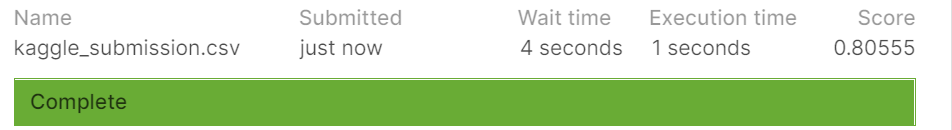